In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch.unitroot import ADF
from statsmodels.tsa.api import VAR
import yfinance as yf
import datetime

In [59]:
end = datetime.datetime.today()
timedelta = datetime.timedelta(days=2 * 365)  # Get 2 years of data
start = end - timedelta
df = yf.download(["BTC-USD", "ETH-USD"], start, end)["Adj Close"]

[*********************100%%**********************]  2 of 2 completed


In [60]:
# Calculate percent changes
df["pct_change_BTC"] = df["BTC-USD"].pct_change()
df["pct_change_ETH"] = df["ETH-USD"].pct_change()
df = df.dropna()
df.head(5)

,BTC-USD,ETH-USD,pct_change_BTC,pct_change_ETH
Date,,,,
2021-12-28,47588.855469,3800.893066,-0.060259,-0.058613
2021-12-29,46444.710938,3628.531738,-0.024042,-0.045348
2021-12-30,47178.125000,3713.852051,0.015791,0.023514
2021-12-31,46306.445312,3682.632812,-0.018476,-0.008406
2022-01-01,47686.812500,3769.697021,0.029809,0.023642


<Axes: xlabel='Date'>

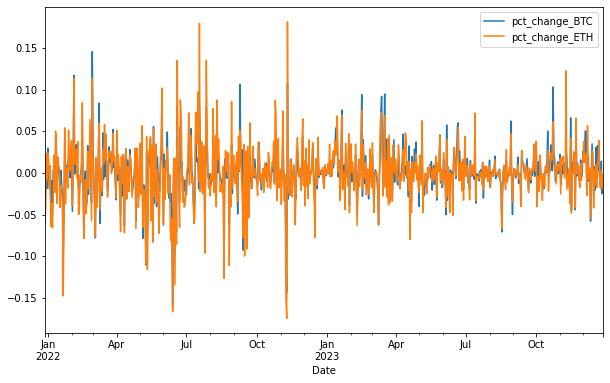

In [61]:
df.loc[:, ["pct_change_BTC", "pct_change_ETH"]].plot(figsize=(10, 6))

In [62]:
# Conduct Augmented Dickey-Fuller tests on pct_change_BTC and pct_change_ETH
ADF_pct_change_BTC = ADF(df["pct_change_BTC"], trend="n", method="bic")
ADF_pct_change_ETH = ADF(df["pct_change_ETH"], trend="n", method="bic")
adf_df = pd.DataFrame({"ADF p-value":[ADF_pct_change_BTC.pvalue, ADF_pct_change_ETH.pvalue]})
adf_df.index = ["pct_change_BTC", "pct_change_ETH"]
adf_df

,ADF p-value
pct_change_BTC,0.0
pct_change_ETH,0.0


As can be seen, because ADF $p$ value is $p < 0.05$, we can decide both percent differences time series are stationary.

In [63]:
pct_data = df.iloc[:, -2:]
pct_data

,pct_change_BTC,pct_change_ETH
Date,,
2021-12-28,-0.060259,-0.058613
2021-12-29,-0.024042,-0.045348
2021-12-30,0.015791,0.023514
2021-12-31,-0.018476,-0.008406
2022-01-01,0.029809,0.023642
...,...,...
2023-12-23,-0.005872,-0.007513
2023-12-24,-0.016539,-0.018776
2023-12-25,0.013879,0.003032


In [64]:
# Fit VAR model and select the best lag
model = VAR(pct_data)
model.select_order(maxlags=12, trend="c").summary()  # show the different AIC and BIC values for different lags and we'll pick the minimum.


/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-15.16*,-15.15*,2.599e-07*,-15.16*
1,-15.16,-15.12,2.617e-07,-15.14
2,-15.15,-15.09,2.635e-07,-15.12
3,-15.15,-15.06,2.644e-07,-15.11
4,-15.14,-15.02,2.669e-07,-15.09
5,-15.13,-14.99,2.696e-07,-15.07
6,-15.13,-14.96,2.689e-07,-15.07
7,-15.12,-14.93,2.702e-07,-15.05
8,-15.13,-14.91,2.696e-07,-15.04
9,-15.13,-14.88,2.697e-07,-15.03


According to the order selection, with an optimum lag of 0, a VAR($p$) model does not seem to improve forecasting power and we don't need a VAR(p) fit.

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch.unitroot import ADF
from statsmodels.tsa.api import VAR
import yfinance as yf
import datetime

# Download last 2 years of data for google, microsoft, amazon and nvidia
end = datetime.datetime.today()
timedelta = datetime.timedelta(days=2 * 365)  # Get 2 years of data
start = end - timedelta
df = yf.download(["GOOG", "MSFT", "AMZN", "NVDA"], start, end)["Adj Close"]

[                       0%%                      ]

[*********************100%%**********************]  4 of 4 completed


In [66]:
df.head()

,AMZN,GOOG,MSFT,NVDA
Date,,,,
2021-12-27,169.669495,148.063995,336.289124,309.023834
2021-12-28,170.660995,146.447998,335.110718,302.802429
2021-12-29,169.201004,146.504501,335.798187,299.596863
2021-12-30,168.644501,146.002502,333.215454,295.452515
2021-12-31,166.716995,144.679504,330.269470,293.704926


<Axes: xlabel='Date'>

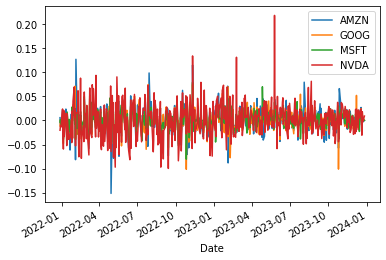

In [67]:
# Create pct_change dataframe
cols = tuple(df.columns)
log_dict = {}
for col in cols:
    log_dict[col] = np.log((df[col] / df[col].shift(1)))
log_df = pd.DataFrame(log_dict, index=df.index).dropna()
log_df.plot()

In [68]:
log_df_VAR = VAR(log_df)
log_df_VAR.select_order(maxlags=12, trend="n").summary()

/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-31.71,-31.58,1.687e-14,-31.66
1,-31.70*,-31.43*,1.706e-14*,-31.59*
2,-31.67,-31.26,1.753e-14,-31.51
3,-31.64,-31.09,1.816e-14,-31.42
4,-31.60,-30.92,1.883e-14,-31.33
5,-31.56,-30.74,1.969e-14,-31.24
6,-31.55,-30.59,1.983e-14,-31.18
7,-31.52,-30.43,2.042e-14,-31.09
8,-31.48,-30.25,2.132e-14,-31.00
9,-31.43,-30.06,2.236e-14,-30.90


Then we select $p=1$ for our VAR($p$) model.

In [69]:
results = VAR(log_df).fit(
    maxlags=None,
    # when maxlags=None criterion to use for VAR order selection is
    # ic{'aic', 'fpe', 'hqic', 'bic', None}
    ic=None,  # ic=None => automatic lag selection
    method="ols",
    trend="n",
    verbose=True,
)
results.summary()

/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Dec, 2023
Time:                     10:18:07
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -31.6288
Nobs:                     501.000    HQIC:                  -31.7106
Log likelihood:           5129.20    FPE:                1.60435e-14
AIC:                     -31.7635    Det(Omega_mle):     1.55412e-14
--------------------------------------------------------------------
Results for equation AMZN
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
L1.AMZN         0.016967         0.067261            0.252           0.801
L1.GOOG        -0.202671         0.086670           -2.338           0.019
L1.MSFT         0.161343         0.105723            1.526           0.127
L1.NVDA   

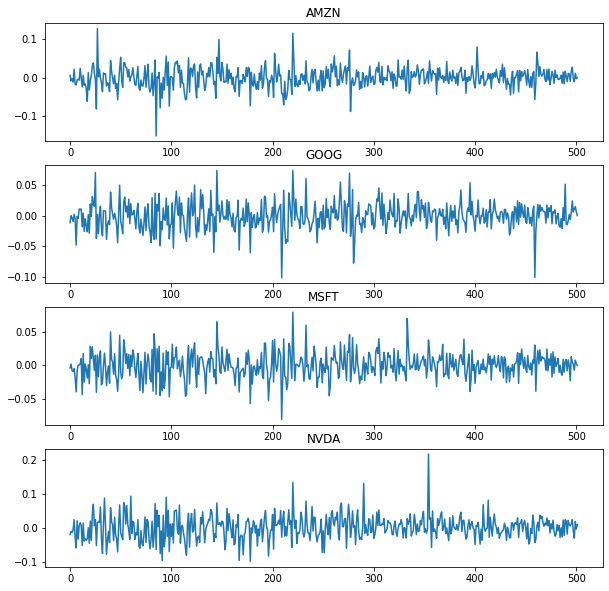

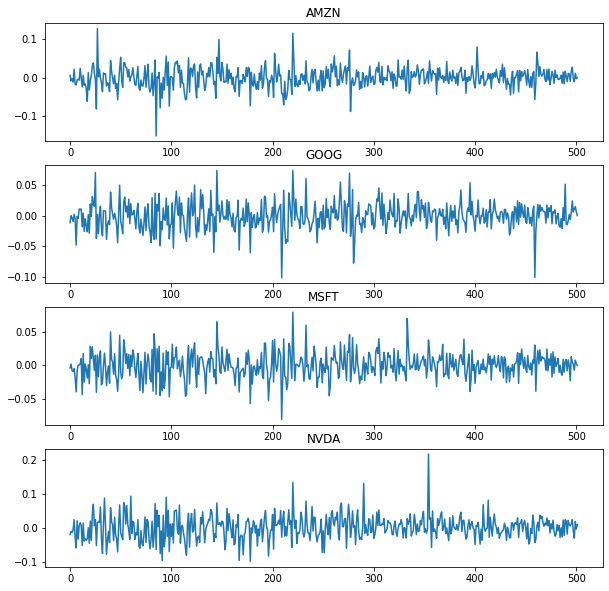

In [70]:
results.plot()

In [71]:
coefs = results.coefs[0]
# const = results.intercept
print(coefs)
# print(const)

[[ 1.69668155e-02 -2.02670528e-01  1.61343224e-01  2.78869164e-03]
 [ 1.82533785e-02 -4.55700646e-02  4.90850889e-02  6.54547621e-05]
 [-7.09644476e-03 -6.74798249e-02  4.19036341e-02  1.01364068e-02]
 [ 1.14001888e-01 -2.63885885e-01  1.54713129e-01  4.70554345e-03]]


In [72]:
# Store coefficients in a dataframe, all lag 1
coef_df_var1 = pd.DataFrame(coefs, columns=["AMZN coef", "GOOG coef", "MSFT coef", "NVDA coef"],
                            index=["AMZN equation", "GOOG equation", "MSFT equation", "NVDA equation"])
coef_df_var1

,AMZN coef,GOOG coef,MSFT coef,NVDA coef
AMZN equation,0.016967,-0.202671,0.161343,0.002789
GOOG equation,0.018253,-0.045570,0.049085,0.000065
MSFT equation,-0.007096,-0.067480,0.041904,0.010136
NVDA equation,0.114002,-0.263886,0.154713,0.004706


Now let's use our VAR(1) model to forecast GOOG percent returns:

/tmp/ipykernel_5859/1935076254.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  log_df[f"Cumulative GOOG VAR(1)_{i}"] = log_df[f"GOOG VAR(1)_{i}"].cumsum()
/tmp/ipykernel_5859/1935076254.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  log_df[f"GOOG VAR(1)_{i}"] = log_df["AMZN"].shift(1) * coef_df_var1.iloc[1, 0] + log_df["GOOG"].shift(1) * coef_df_var1.iloc[1, 1] + log_df["MSFT"].shift(1) * coef_df_var1.iloc[1, 2] + log_df["NVDA"].shift(1) * coef_df_var1.iloc[1, 3] + np.random.normal(0, log_df.loc[:, ["GOOG"]].std(), len(

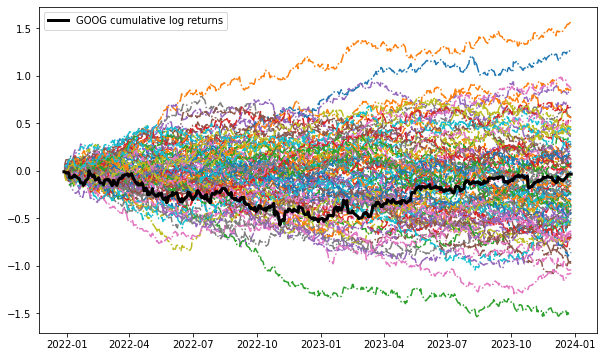

In [73]:

size = 100
for i in range(size):
    log_df[f"GOOG VAR(1)_{i}"] = log_df["AMZN"].shift(1) * coef_df_var1.iloc[1, 0] + log_df["GOOG"].shift(1) * coef_df_var1.iloc[1, 1] + log_df["MSFT"].shift(1) * coef_df_var1.iloc[1, 2] + log_df["NVDA"].shift(1) * coef_df_var1.iloc[1, 3] + np.random.normal(0, log_df.loc[:, ["GOOG"]].std(), len(log_df.loc[:, ["GOOG"]]))
    log_df[f"Cumulative GOOG VAR(1)_{i}"] = log_df[f"GOOG VAR(1)_{i}"].cumsum()
log_df["Cumulative GOOG"] = log_df["GOOG"].cumsum()
# log_df["Cumulative GOOG VAR(1)"] = log_df["GOOG VAR(1)"].cumsum()
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(size):
    ax.plot(log_df.index, log_df[f"Cumulative GOOG VAR(1)_{i}"], linestyle="-.")
ax.plot(log_df.index, log_df["Cumulative GOOG"], linestyle="-", linewidth=3, label="GOOG cumulative log returns", color="black")
ax.legend()


> As we can see, this is a shit fit that has no use whatsoever.

Now, let's use MORE data:

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch.unitroot import ADF
from statsmodels.tsa.api import VAR
import yfinance as yf
import datetime

# Download last 2 years of data for google, microsoft, amazon and nvidia
end = datetime.datetime.today()
timedelta = datetime.timedelta(days=2 * 365)  # Get 2 years of data
start = end - timedelta
df = yf.download(["GOOG", "MSFT", "AMZN", "NVDA", "AAPL", "META", "TSLA", "HSBC"], start, end)["Adj Close"]

[*********************100%%**********************]  8 of 8 completed


In [75]:
df.head()

,AAPL,AMZN,GOOG,HSBC,META,MSFT,NVDA,TSLA
Date,,,,,,,,
2021-12-27,178.292862,169.669495,148.063995,26.898523,346.179993,336.289185,309.023865,364.646667
2021-12-28,177.264572,170.660995,146.447998,26.970085,346.220001,335.110718,302.802429,362.823334
2021-12-29,177.353622,169.201004,146.504501,27.032703,342.940002,335.798126,299.596832,362.063324
2021-12-30,176.186935,168.644501,146.002502,26.987978,344.359985,333.215424,295.452515,356.779999
2021-12-31,175.564072,166.716995,144.679504,26.970085,336.350006,330.269409,293.704895,352.260010


<Axes: xlabel='Date'>

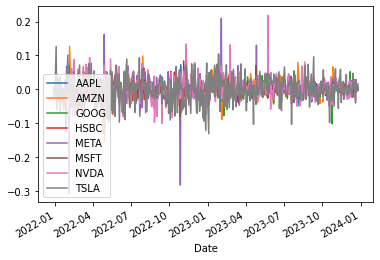

In [76]:
# Create pct_change dataframe
cols = tuple(df.columns)
log_dict = {}
for col in cols:
    log_dict[col] = np.log((df[col] / df[col].shift(1)))
log_df = pd.DataFrame(log_dict, index=df.index).dropna()
log_df.plot()

In [77]:
log_df_VAR = VAR(log_df)
log_df_VAR.select_order(maxlags=12, trend="n").summary()

/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-63.32,-62.77,3.169e-28,-63.10
1,-63.22*,-62.12*,3.504e-28*,-62.79*
2,-63.13,-61.48,3.847e-28,-62.48
3,-63.04,-60.84,4.211e-28,-62.18
4,-62.90,-60.16,4.852e-28,-61.82
5,-62.80,-59.51,5.367e-28,-61.51
6,-62.74,-58.90,5.728e-28,-61.23
7,-62.61,-58.23,6.491e-28,-60.89
8,-62.51,-57.58,7.252e-28,-60.57
9,-62.38,-56.90,8.322e-28,-60.23


Then we proceed with a VAR($1$) model.

In [78]:
results = VAR(log_df).fit(
    maxlags=None,
    # when maxlags=None criterion to use for VAR order selection is
    # ic{'aic', 'fpe', 'hqic', 'bic', None}
    ic=None,  # ic=None => automatic lag selection
    method="ols",
    trend="n",
    verbose=True,
)
results.summary()

/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Dec, 2023
Time:                     10:18:10
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -62.8382
Nobs:                     501.000    HQIC:                  -63.1655
Log likelihood:           10252.8    FPE:                2.99098e-28
AIC:                     -63.3768    Det(Omega_mle):     2.63495e-28
--------------------------------------------------------------------
Results for equation AAPL
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
L1.AAPL        -0.055097         0.076833           -0.717           0.473
L1.AMZN         0.061252         0.047730            1.283           0.199
L1.GOOG        -0.029739         0.063325           -0.470           0.639
L1.HSBC   

Let's forecast AMZN price using 1 lags of AAPL, META, MSFT:

In [79]:
coefs = results.coefs[0]
# const = results.intercept
print(coefs)
# print(const)

[[-0.05509652  0.06125212 -0.02973856  0.00386733 -0.04501989  0.12334495
   0.02351588 -0.04694895]
 [-0.18768272  0.07975261 -0.08541581 -0.00698554 -0.13748637  0.249366
   0.05803728 -0.04165619]
 [-0.20646641  0.0437686   0.01899239  0.09850399 -0.0359396   0.11479515
   0.03085601 -0.02821382]
 [-0.0338196   0.11635613 -0.11458259 -0.0381525   0.00771768 -0.03367262
   0.01735444  0.00517803]
 [-0.42074551  0.01920328 -0.10616611  0.03848429 -0.00542166  0.535301
   0.01850648 -0.04746696]
 [-0.13368669  0.02350288 -0.01256391  0.02965566 -0.04389606  0.09003015
   0.04490681 -0.03832639]
 [-0.06737668  0.14784115 -0.22191029 -0.02241299 -0.04284761  0.18389734
   0.04340744 -0.05202569]
 [ 0.16505275  0.05894343 -0.1866407  -0.01149364 -0.0361436   0.09968365
   0.05057864 -0.08987725]]


In [80]:
coefs_dict = {"AAPL":coefs[1, 0], "META":coefs[1, 4], "MSFT":coefs[1, 5]}
coefs_dict

{'AAPL': -0.18768272264396704,
 'META': -0.13748636981646267,
 'MSFT': 0.24936600111164584}

<Axes: xlabel='Date'>

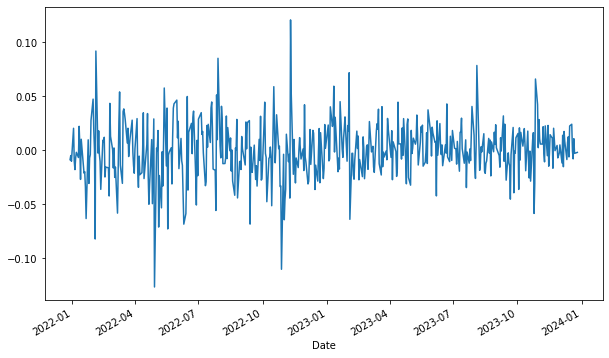

In [83]:
AMZN_var1 = np.sum(np.array([coefs_dict[ticker]*log_df[ticker].shift(1) for ticker in ["AAPL", "META", "MSFT"]]), axis=0)
log_df["AMZN VAR(1)"] = AMZN_var1
AMZN_resid = log_df["AMZN"] - log_df["AMZN VAR(1)"]
resid_std = AMZN_resid.std()
AMZN_resid.plot(figsize=(10, 6))

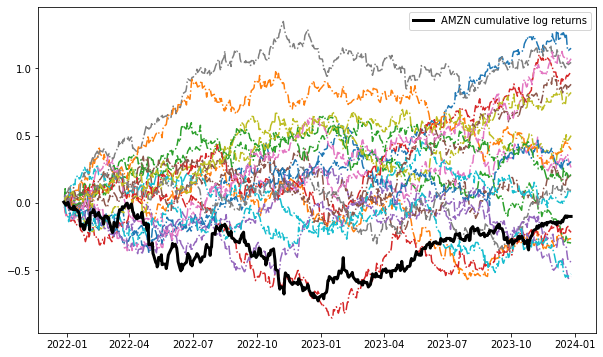

In [82]:
size = 20
for i in range(size):
    log_df[f"AMZN_VAR_{i}"] = AMZN_var1 + np.random.normal(0, resid_std, len(log_df["AMZN VAR(1)"]))
    log_df[f"Cumulative AMZN_VAR_{i}"] = log_df[f"AMZN_VAR_{i}"].cumsum()
log_df["Cumulative AMZN"] = log_df["AMZN"].cumsum()
    
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(size):
    ax.plot(log_df.index, log_df[f"Cumulative AMZN_VAR_{i}"], linestyle="-.")
ax.plot(log_df.index, log_df["Cumulative AMZN"], linestyle="-", linewidth=3, label="AMZN cumulative log returns", color="black")
ax.legend()